# Siamese Network
Network for a Face Recognition System

# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Dataset

## Utility Functions

In [ ]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

## Prepare Data

In [ ]:
# Get the GDrive paths
# https://drive.google.com/file/d/1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw/view?usp=sharing
!gdown 'https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw'

Downloading...
From: https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw
To: /content/olivetti.zip
100% 1.90M/1.90M [00:00<00:00, 130MB/s]


In [ ]:
# Unzip the file
!unzip /content/olivetti.zip

Archive:  /content/olivetti.zip
  inflating: olivetti_faces.npy      
  inflating: olivetti_faces_target.npy  


In [ ]:
# Get the data directory paths
faces = '/content/olivetti_faces.npy'
faces_targets = '/content/olivetti_faces_target.npy'

In [ ]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [ ]:
target_shape = face_images[0].shape

In [ ]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [ ]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

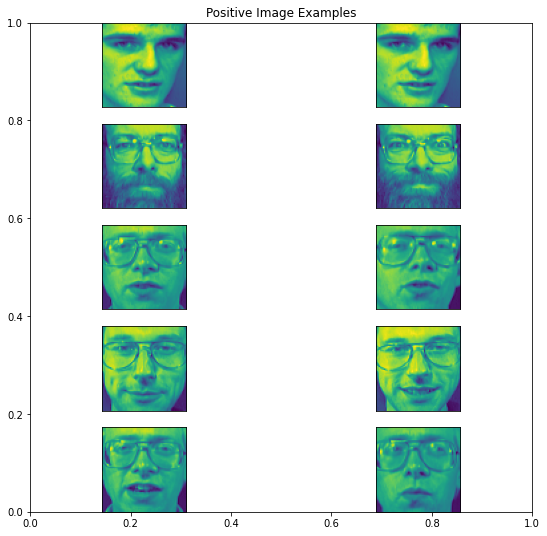

In [ ]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

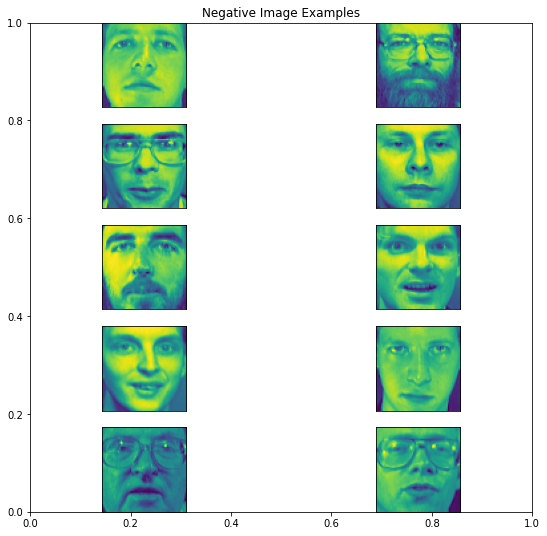

In [ ]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [ ]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [ ]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
checkpoints = ModelCheckpoint('Model' + '{accuracy:.2f}acc.h5', verbose=1) # Create Keras SavedModel as checkpoints

In [ ]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 16s 190ms/step - loss: 0.6758 - accuracy: 0.4906 - val_loss: 0.6643 - val_accuracy: 0.6062
Epoch 2/150
10/10 [==============================] - 1s 124ms/step - loss: 0.6453 - accuracy: 0.4906 - val_loss: 0.6233 - val_accuracy: 0.6000
Epoch 3/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6355 - accuracy: 0.4922 - val_loss: 0.6094 - val_accuracy: 0.6125
Epoch 4/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6202 - accuracy: 0.4938 - val_loss: 0.5933 - val_accuracy: 0.5875
Epoch 5/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6172 - accuracy: 0.5000 - val_loss: 0.5835 - val_accuracy: 0.6187
Epoch 6/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6119 - accuracy: 0.5000 - val_loss: 0.5933 - val_accuracy: 0.6438
Epoch 7/150
10/10 [==============================] - 1s 117ms/step - loss: 0.6051 - accuracy: 0.5219 - val_loss: 0.5710 - val_accuracy: 0.637

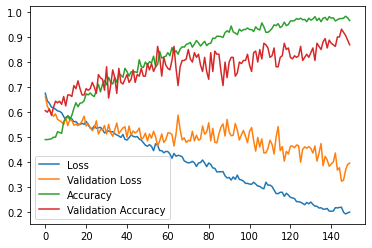

In [ ]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

# Testing

In [ ]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

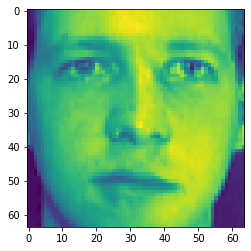

In [ ]:
plt.imshow(test_image)

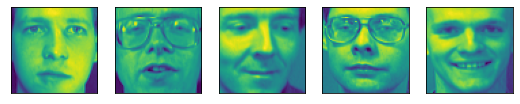

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [ ]:
image_pairs.shape

(5, 2, 64, 64)

In [ ]:
image_pairs[:,0,:]

array([0.3429752 , 0.40495867, 0.43801653, 0.47107437, 0.553719  ,
       0.62396693, 0.6694215 , 0.6859504 , 0.69008267, 0.6859504 ,
       0.6942149 , 0.69008267, 0.6983471 , 0.70247936, 0.6983471 ,
       0.6942149 , 0.7066116 , 0.7107438 , 0.7107438 , 0.71487606,
       0.7107438 , 0.70247936, 0.71900827, 0.72727275, 0.7355372 ,
       0.76033056, 0.7768595 , 0.78512394, 0.78099173, 0.7768595 ,
       0.77272725, 0.7892562 , 0.78512394, 0.77272725, 0.7644628 ,
       0.74793386, 0.74380165, 0.73966944, 0.7355372 , 0.71900827,
       0.71900827, 0.71900827, 0.71900827, 0.71900827, 0.71900827,
       0.7231405 , 0.72727275, 0.71900827, 0.72727275, 0.71900827,
       0.71900827, 0.7231405 , 0.7066116 , 0.70247936, 0.6983471 ,
       0.6735537 , 0.6570248 , 0.6363636 , 0.60330576, 0.5123967 ,
       0.44214877, 0.37190083, 0.338843  , 0.3140496 ], dtype=float32)

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [ ]:
print(score)

[[7.9160875e-01]
 [1.6307978e-01]
 [2.9741693e-04]
 [5.1610527e-04]
 [1.0154147e-03]]


## Test 2

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

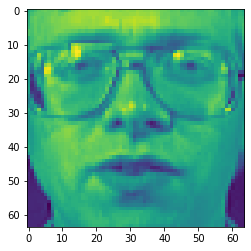

In [ ]:
plt.imshow(test_image)

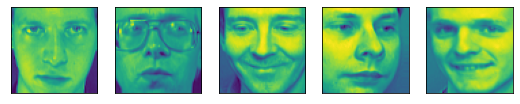

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [ ]:
print(score)

[[0.16540621]
 [0.77440196]
 [0.00238901]
 [0.00238309]
 [0.0014122 ]]
